In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch_geometric.utils import to_networkx, negative_sampling, to_dense_adj
from torch_geometric.datasets import KarateClub

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
data = KarateClub()[0]

In [3]:
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

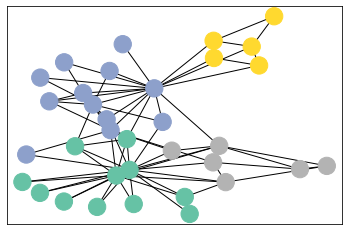

In [4]:
G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=data.y, cmap="Set2")

In [5]:
# no features, just node ids

data.x = torch.arange(data.num_nodes) # node idx

In [6]:
from torch_geometric.nn.models import VGAE
from torch_geometric.nn import GCNConv

In [8]:
class VariationalConvEncoder(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):
        
        super().__init__()
        
        self.emb = nn.Embedding(num_nodes, embedding_dim)
        
        self.mu = GCNConv(embedding_dim, embedding_dim)
        
        self.logvar = GCNConv(embedding_dim, embedding_dim)
        
    def forward(self, x, edge_index):
        
        x = self.emb(x)
        
        return self.mu(x, edge_index), self.logvar(x, edge_index)

In [12]:
class ConvVGAE(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):

        super().__init__()

        self.vgae = VGAE(
            encoder=VariationalConvEncoder(num_nodes, embedding_dim),
            decoder=None
        )
    
    @torch.no_grad()
    def get_embeddings(self, x, edge_index):
                
        return self.vgae.encode(x, edge_index).numpy()

    def visualize(self, x, edge_index):

        """visulize embeddings with PCA"""

        node_embeddings = self.get_embeddings(x, edge_index)

        node_cmp = PCA(n_components=2).fit_transform(node_embeddings)

        y = data.y.numpy()

        plt.scatter(node_cmp[:, 0], node_cmp[:, 1], s=140, c=y, cmap="Set2")

        plt.show()

    def train_model(self, x, edge_index, n_steps, opt):

        """train model given x, edge_index, n_steps and opt"""

        for i in tqdm(range(n_steps)):
            
            if i % 100 == 0:

                print(f'epoch={i}')

                self.visualize(x, edge_index)
            
            # the GAE do the reparametrization for us
            # z = std * noise + mu
            z = self.vgae.encode(x, edge_index)
            
            # reconstruction loss
            loss = self.vgae.recon_loss(z, edge_index)
            
            # KL regularizer
            loss = loss + (1 / len(x)) * self.vgae.kl_loss()

            loss.backward()

            opt.step()

            opt.zero_grad()

In [13]:
model = ConvVGAE(data.num_nodes, 16)

opt = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.01)

  0%|          | 0/500 [00:00<?, ?it/s]

epoch=0


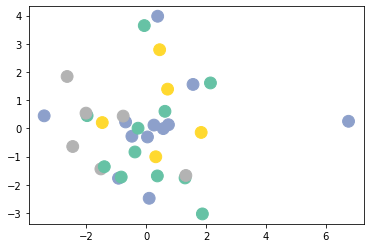

 17%|█▋        | 87/500 [00:00<00:01, 243.75it/s]

epoch=100


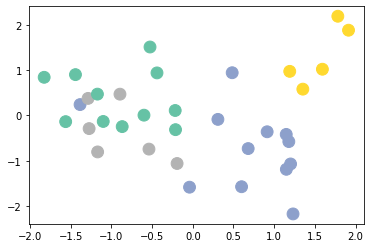

 38%|███▊      | 190/500 [00:00<00:01, 235.43it/s]

epoch=200


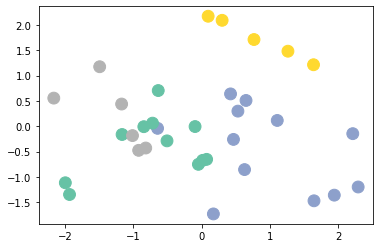

 60%|█████▉    | 299/500 [00:01<00:00, 245.12it/s]

epoch=300


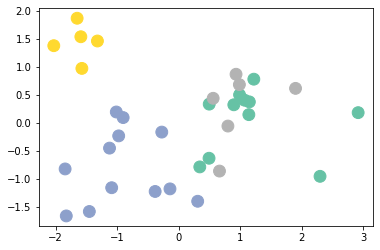

 76%|███████▌  | 381/500 [00:01<00:00, 236.62it/s]

epoch=400


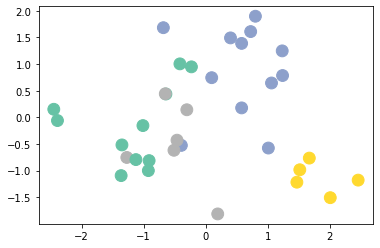

100%|██████████| 500/500 [00:02<00:00, 219.80it/s]


In [14]:
model.train_model(data.x, data.edge_index, 500, opt)